In [1]:
import yfinance as yf

In [2]:
import pyspark

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark=SparkSession.builder.appName("Gold").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/06 00:05:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
spark

In [6]:
from pyspark.sql.functions import col, stddev, mean
from pyspark.sql.window import Window

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

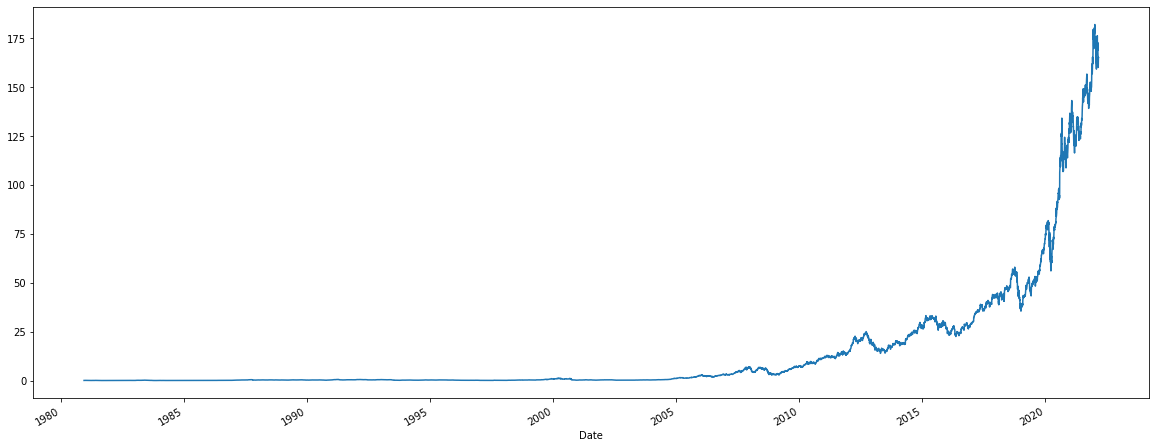

In [7]:
# Fetch data from yfinance
data = yf.download("AAPL", start="1980-01-01", end="2022-03-01", interval="1d")
data['Close'].plot(figsize = (20,8)) 

In [8]:
# Convert the pandas DataFrame to a PySpark DataFrame
df = spark.createDataFrame(data.reset_index()).select(['Date','Open','Close'])
df.count()

10391

In [19]:
# Calculate the rolling mean and standard deviation of the closing price
window = Window.orderBy(col("Date")).rowsBetween(-200, 0)
df = df.withColumn("rolling_mean", mean(col("Close")).over(window)) \
       .withColumn("rolling_stddev", stddev(col("Close")).over(window)).na.drop()

In [20]:
# Show the PySpark DataFrame
df.show(4)

23/03/06 00:13:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/03/06 00:13:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+-------------------+-------------------+-------------------+-------------------+--------------------+
|               Date|               Open|              Close|       rolling_mean|      rolling_stddev|
+-------------------+-------------------+-------------------+-------------------+--------------------+
|1980-12-16 00:00:00| 0.1132809

# converting to pandas for visualization

In [21]:
import matplotlib.pyplot as plt

In [22]:
pdf = df.toPandas()

23/03/06 00:13:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/03/06 00:13:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/06 00:13:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [23]:
pdf.head()

,Date,Open,Close,rolling_mean,rolling_stddev
0,1980-12-16,0.113281,0.112723,0.117188,0.006314
1,1980-12-17,0.115513,0.115513,0.116629,0.004568
2,1980-12-18,0.118862,0.118862,0.117188,0.003893
3,1980-12-19,0.126116,0.126116,0.118973,0.005226
4,1980-12-22,0.132254,0.132254,0.121187,0.007159


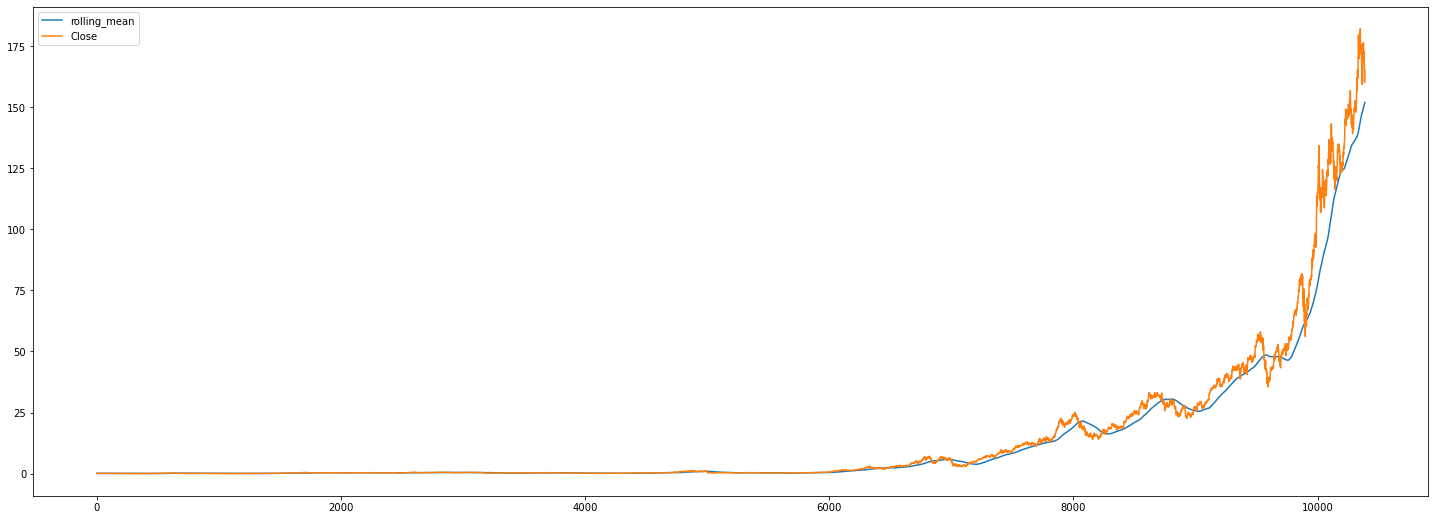

In [24]:
# Visualizing the rolling_mean
pdf.rolling_mean.plot(figsize=(25,9))
pdf['Close'].plot()
#pdf.Open.plot()
plt.legend(['rolling_mean','Close'])

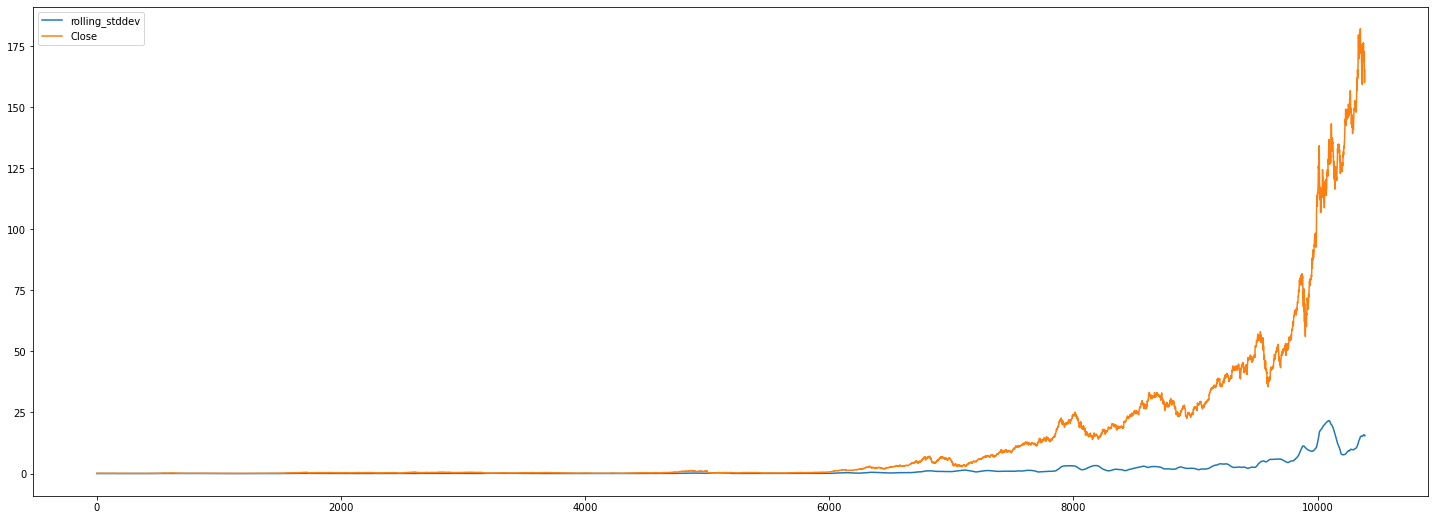

In [25]:
# Visualizing the rolling_mean
pdf.rolling_stddev.plot(figsize=(25,9))
pdf['Close'].plot()
#pdf.Open.plot()
plt.legend(['rolling_stddev','Close'])

In [ ]:
## Lets define the dataset column type 
df_pyspark = spark.read.option('header', 'true').csv(all_data, inferSchema=True)
df_pyspark.show(5)

In [ ]:
# Calculate the size of the DataFrame in bytes
size_bytes = df_pyspark.rdd.map(lambda x: x.__sizeof__()).reduce(lambda a, b: a + b)

# Convert the size to gigabytes
size_gb = size_bytes / (1024.0 ** 3)

# Print the size in gigabytes
print("DataFrame size: {:.2f} GB".format(size_gb))

In [ ]:
df_pyspark = spark.createDataFrame(x, ["file", "message"])
df_pyspark.show(5)

In [11]:
df_pyspark.show(10)

+--------------------+--------------------+
|                file|             message|
+--------------------+--------------------+
|allen-p/_sent_mai...|Message-ID: <1878...|
|allen-p/_sent_mai...|Message-ID: <1546...|
|allen-p/_sent_mai...|Message-ID: <2421...|
|allen-p/_sent_mai...|Message-ID: <1350...|
|allen-p/_sent_mai...|Message-ID: <3092...|
+--------------------+--------------------+



In [20]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import udf

# Define a UDF to parse email message and extract sender and receiver
def parse_email_message(message):
    e = email.message_from_string(message)
    sender = e.get('From')
    reciever = e.get('To')
    return (sender, reciever)

# Define the schema for the struct type
email_schema = StructType([
    StructField('Sender', StringType(), True),
    StructField('Receiver', StringType(), True)
])

# Convert the UDF to return a struct type
parse_email_message_udf = udf(parse_email_message, email_schema)

# Add columns for sender and receiver using the UDF
df_pyspark = df_pyspark.withColumn('EmailData', parse_email_message_udf('message'))
df_pyspark = df_pyspark.withColumn('Sender', df_pyspark['EmailData']['Sender'])
df_pyspark = df_pyspark.withColumn('Receiver', df_pyspark['EmailData']['Receiver'])
# Select only the necessary columns

df_pyspark.show(15)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                file|             message|           EmailData|              Sender|            Receiver|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|allen-p/_sent_mai...|Message-ID: <1878...|{phillip.allen@en...|phillip.allen@enr...|tim.belden@enron.com|
|allen-p/_sent_mai...|Message-ID: <1546...|{phillip.allen@en...|phillip.allen@enr...|john.lavorato@enr...|
|allen-p/_sent_mai...|Message-ID: <2421...|{phillip.allen@en...|phillip.allen@enr...|leah.arsdall@enro...|
|allen-p/_sent_mai...|Message-ID: <1350...|{phillip.allen@en...|phillip.allen@enr...|randall.gay@enron...|
|allen-p/_sent_mai...|Message-ID: <3092...|{phillip.allen@en...|phillip.allen@enr...|greg.piper@enron.com|
+--------------------+--------------------+--------------------+--------------------+--------------------+



In [14]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import udf

# Define a UDF to parse email message and extract sender and receiver
def parse_email_message(message):
    e = email.message_from_string(message)
    e = email.message_from_string(message)
    sender = e.get('From')
    reciever = e.get('To')
    #print(f"Message: {message}")
    #print(f"Sender: {sender}")
    #print(f"Receiver: {reciever}")
    #return (sender, reciever)

# Define the schema for the struct type
email_schema = StructType([
    StructField('Sender', StringType(), True),
    StructField('Receiver', StringType(), True)
])

# Convert the UDF to return a struct type
parse_email_message_udf = udf(parse_email_message, email_schema)

# Add columns for sender and receiver using the UDF
df_pyspark = df_pyspark.withColumn('EmailData', parse_email_message_udf('message'))
df_pyspark = df_pyspark.withColumn('Sender', df_pyspark['EmailData']['Sender'])
df_pyspark = df_pyspark.withColumn('Receiver', df_pyspark['EmailData']['Receiver'])

# Show the first few rows of the DataFrame
df_pyspark.show(5)


+--------------------+--------------------+---------+------+--------+
|                file|             message|EmailData|Sender|Receiver|
+--------------------+--------------------+---------+------+--------+
|allen-p/_sent_mai...|Message-ID: <1878...|     null|  null|    null|
|allen-p/_sent_mai...|Message-ID: <1546...|     null|  null|    null|
|allen-p/_sent_mai...|Message-ID: <2421...|     null|  null|    null|
|allen-p/_sent_mai...|Message-ID: <1350...|     null|  null|    null|
|allen-p/_sent_mai...|Message-ID: <3092...|     null|  null|    null|
+--------------------+--------------------+---------+------+--------+

